<a href="https://colab.research.google.com/github/AnujBalodi916/Named-Entity-Recognition/blob/main/NER_Anuj_Balodi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.17.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv("/content/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

<ipython-input-2-79dabc23a0aa>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 33424
Unique tags in corpus: 17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

<ipython-input-6-ec4b8e38ba61>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [8]:
sentences[0]

[('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
word2idx

{'Clothes': 1,
 'Zedong': 2,
 'Agent': 3,
 'recommit': 4,
 'intergovernmental': 5,
 'two-million': 6,
 'coalitions': 7,
 'until': 8,
 'Ntini': 9,
 'enjoying': 10,
 'Sahafi': 11,
 'been': 12,
 'nook': 13,
 '05-Apr': 14,
 'affront': 15,
 'Filipinos': 16,
 '141': 17,
 'shipped': 18,
 'Elliott': 19,
 'pleased': 20,
 'replied': 21,
 'suburb': 22,
 'Mocny': 23,
 'Georgian': 24,
 'barter': 25,
 'Reinsurers': 26,
 'tubes': 27,
 'Carmona': 28,
 'haze-hit': 29,
 'Sharing': 30,
 '6-month': 31,
 'radical': 32,
 'dousing': 33,
 'grueling': 34,
 'small-cell': 35,
 'Inadequate': 36,
 'liquified': 37,
 'archival': 38,
 'occurring': 39,
 'Higüey': 40,
 'detained': 41,
 'ace': 42,
 'Senegalese': 43,
 'anti-cholesterol': 44,
 'clinging': 45,
 'Tomorrow': 46,
 'formerly': 47,
 'wicket': 48,
 'merchants': 49,
 'Auschwitz': 50,
 'Cameroon': 51,
 'Benita': 52,
 'Plainclothes': 53,
 'Apondi': 54,
 'Yassin': 55,
 'donate': 56,
 'fulfill': 57,
 'sow': 58,
 'centuries': 59,
 'wayside': 60,
 'humanitarian': 61,
 

### Task 5: Padding Input Sentences and Creating Train/Test Splits

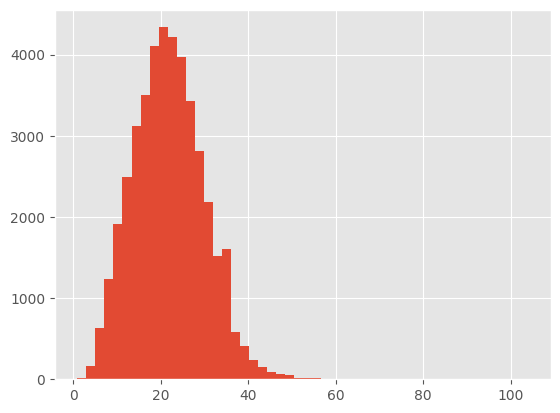

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 50)              │       1,671,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,795,467 (6.85 MB)

 Trainable params: 1,795,467 (6.85 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [17]:
!pip install livelossplot


### Task 7: Train the Model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

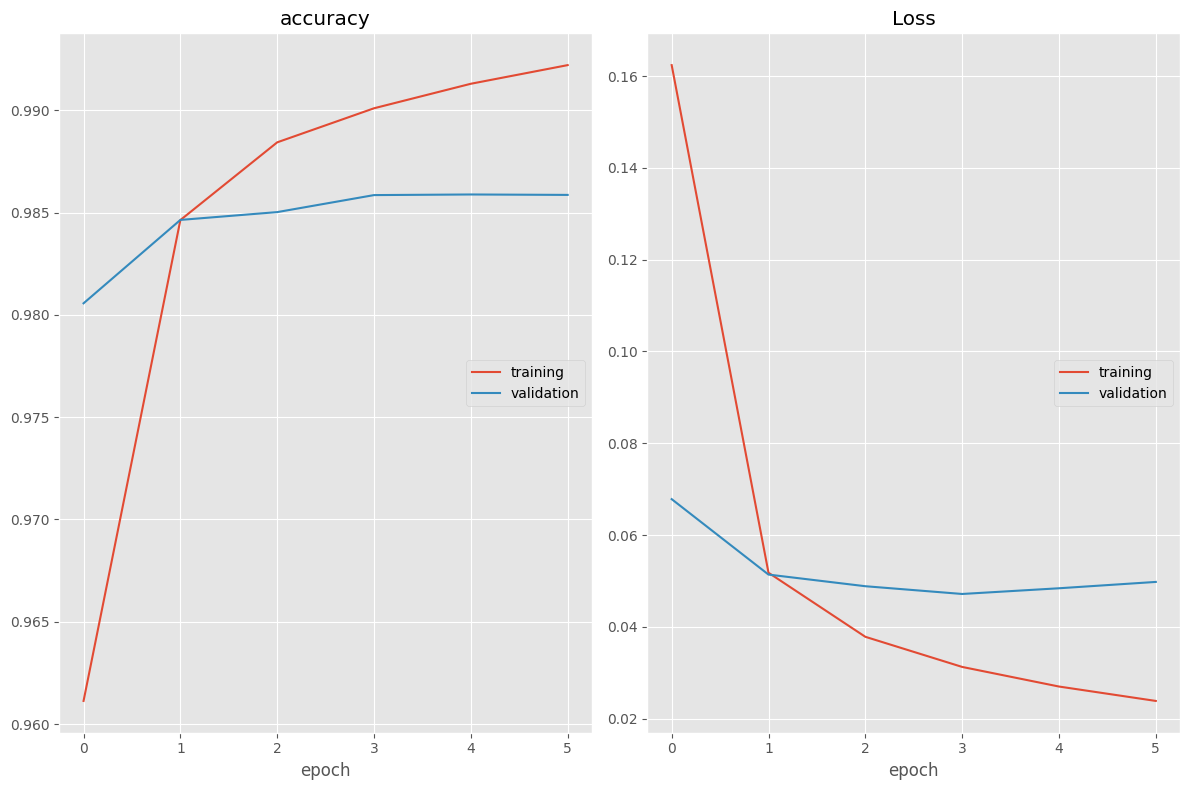

accuracy
	training         	 (min:    0.961, max:    0.992, cur:    0.992)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.024, max:    0.162, cur:    0.024)
	validation       	 (min:    0.047, max:    0.068, cur:    0.050)

Epoch 6: val_loss did not improve from 0.04715
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 205s 164ms/step - accuracy: 0.9925 - loss: 0.0234 - val_accuracy: 0.9859 - val_loss: 0.0498
CPU times: user 24min 38s, sys: 2min 26s, total: 27min 4s
Wall time: 19min 49s


In [19]:
%%time

from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

chkpt = ModelCheckpoint("model_weights.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesKeras(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=9,
    callbacks=callbacks,
    verbose=1
)


### Task 8: Evaluate Named Entity Recognition Model

In [ ]:
model.evaluate(x_test, y_test)

9592/9592 [==============================] - 12s 1ms/sample - loss: 0.0484 - accuracy: 0.9856


[0.04835232572507321, 0.9855588]

In [20]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Word           True 	 Pred

------------------------------
Pirates        O	O
have           O	O
attacked       O	O
many           O	O
ships          O	O
off            O	O
the            O	O
Somali         B-gpe	B-gpe
coast          O	O
,              O	O
including      O	O
a              O	O
United         B-org	B-org
Nations        I-org	I-org
World          I-org	I-org
Food           I-org	I-org
Program        I-org	O
vessel         O	O
hijacked       O	O
last           O	O
year           O	O
.              O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Responsibility O	O
Res